In [1]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## for processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## for doc2vec text embeddings
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts

## for clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import utils

##Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from tqdm import tqdm

pd.options.display.precision = 4
pd.set_option("display.max_rows", 5000)
pd.options.display.max_columns = 999
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

import time
import helpers

# <span class="bg-primary">NLP : Text embeddings<span>
## - __doc2vec de gensim__   
# <span class="bg-danger">SOMMAIRE<span>

In [17]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# <span class="bg-danger">Introduction<span>
    
__Buts de la mission:__

- Réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

- Analyser le jeu de données en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering.

__Contraintes:__
    
Mettre en œuvre a minima un __algorithme de type SIFT / ORB / SURF pour  extraire les features__  

# <span class="bg-danger">Pipeline<span>

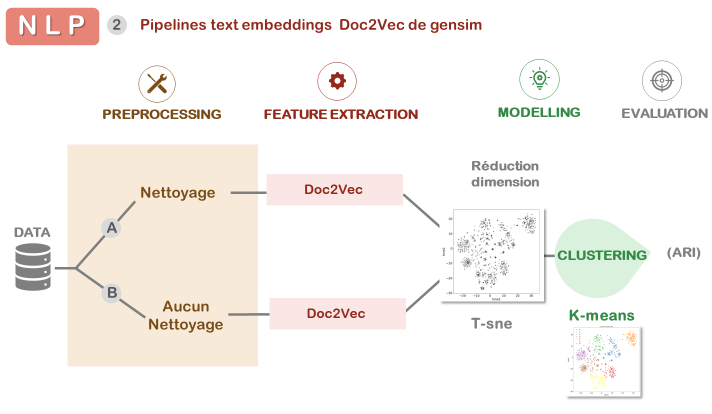

In [3]:
from pyquickhelper.helpgen import NbImage
NbImage("pipeline_doc2vec.png")

In [2]:
import gensim

def read_corpus(df, column, tokens_only=False):
    """
    Arguments
    ---------
        df: pd.DataFrame
        column: str 
            text column name
        tokens_only: bool
            wether to add tags or not
    """
    for i, line in enumerate(df[column]):

        tokens = gensim.parsing.preprocess_string(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

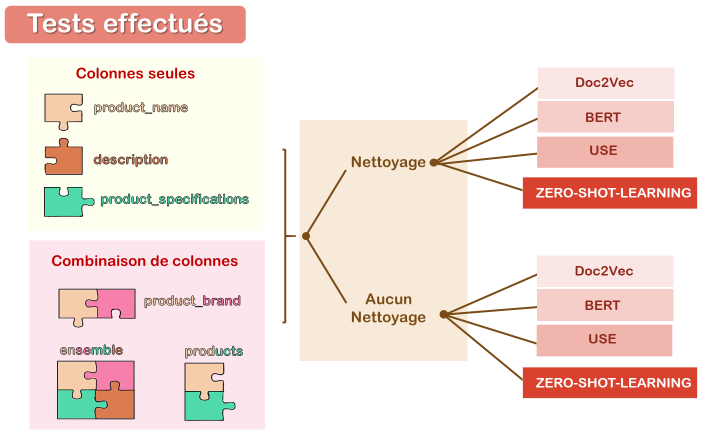

In [1]:
from pyquickhelper.helpgen import NbImage
NbImage("tests_colonnes.png")

## <span class="bg-info"> 1. Sans nettoyage du jeu de données<span>

### <span class="bg-success"> 1.1 Essais colonne product_name doc2vec<span> 

Le mode PV-DBOW s'entraîne rapidement et fonctionne souvent très bien sur les shortish-docs (quelques dizaines de mots). Notez cependant que ce mode n'entraîne pas les vecteurs de mots utilisables, à moins que d'ajouter également l'option dbow_words=1, ce qui ralentit l'entraînement.


1050
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.032s...
[t-SNE] Computed neighbors for 1050 samples in 0.607s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.534641
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.836235
[t-SNE] KL divergence after 1900 iterations: 0.447769


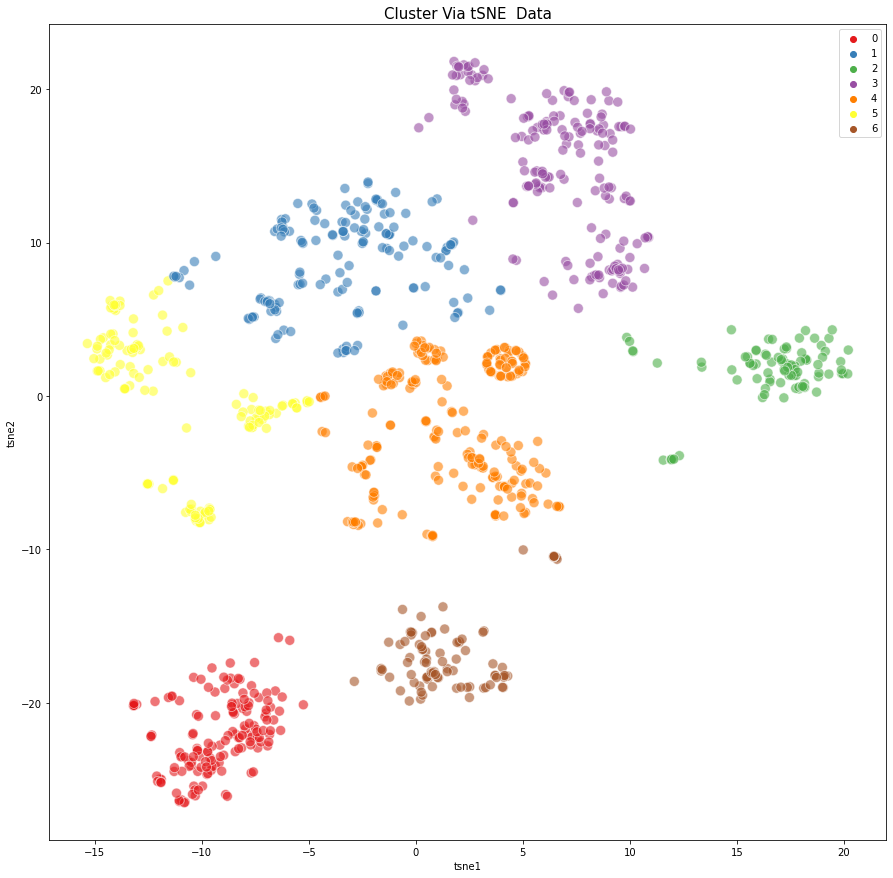

Adjusted Rand Index: 0.539


In [3]:
#=========================================  Tsne puis K means =========================================================

#jeu de données
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df['cat_1']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])

#corpus
product_name_corpus = (list(read_corpus(df, 'product_name'))) 

# using distributed memory model
model = gensim.models.doc2vec.Doc2Vec(dm=0, dbow_words=1, vector_size=300, min_count=5, dm_mean=1, epochs=100, seed=42, workers=8, hs=0, neagative=5)
model.build_vocab(product_name_corpus)
#train model
model.train(product_name_corpus, total_examples=model.corpus_count, epochs=model.epochs)

print(len(model.docvecs.doctag_syn0))

tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(model.docvecs.doctag_syn0)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])


kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)


plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

df['cluster_pn'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_pn']
from sklearn import metrics
ari_doc2vec_pname = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

### <span class="bg-success"> 1.2 Essais colonne description doc2vec<span> 

1050
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.032s...
[t-SNE] Computed neighbors for 1050 samples in 0.562s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.295866
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.879612
[t-SNE] KL divergence after 1950 iterations: 0.715185


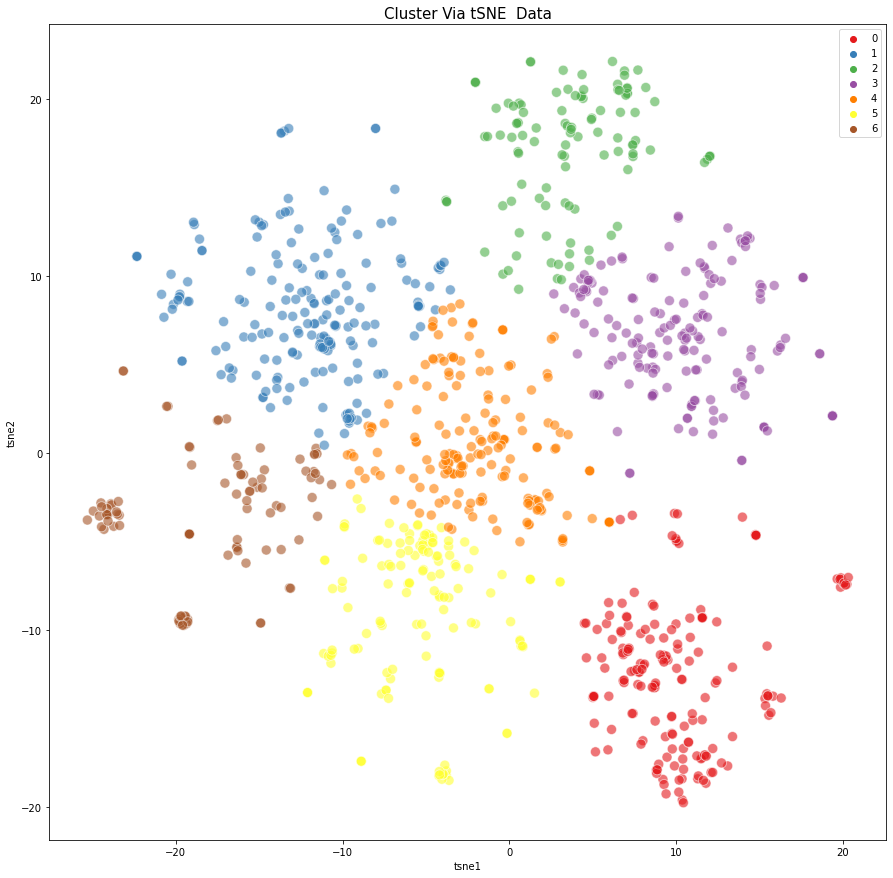

Adjusted Rand Index: 0.571


In [9]:
#=========================================  Tsne puis K means =========================================================

#jeu de données
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df['cat_1']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])

#corpus
description_corpus = (list(read_corpus(df, 'description'))) 

# using distributed memory model
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=300, min_count=5, dm_mean=0, epochs=100, seed=42, workers=8)
model.build_vocab(description_corpus)
#train model
model.train(description_corpus, total_examples=model.corpus_count, epochs=model.epochs)

print(len(model.docvecs.doctag_syn0))

tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(model.docvecs.doctag_syn0)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])


kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)


plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

df['cluster_d'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_d']
from sklearn import metrics
ari_doc2vec_desc = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

#### Analyse du clustering

In [13]:
df.groupby('cluster_d')['cat_1'].value_counts().to_frame()

cat_1
cluster_d cat_1                            
0         Home Decor & Festive Needs    122
          Kitchen & Dining               41
          Baby Care                      18
          Beauty and Personal Care       10
          Computers                       1
1         Beauty and Personal Care      115
          Computers                      30
          Kitchen & Dining               20
          Baby Care                      14
          Home Decor & Festive Needs      5
          Home Furnishing                 1
2         Computers                     119
          Beauty and Personal Care       17
          Kitchen & Dining                8
          Home Decor & Festive Needs      5
3         Watches                       150
          Beauty and Personal Care        1
4         Home Furnishing               130
          Baby Care                      15
          Beauty and Personal Care        2
          Home Decor & Festive Needs      2
          Kitchen & Dining                1
5         Kitchen & Dining               80
          Home Decor & Festive Needs     16
          Beauty and Personal Care        2
          Baby Care                       1
6         Baby Care                     102
          Home Furnishing                19
          Beauty and Personal Care        3

#### Clusters :
- __0__ : Home Decor & Festive Needs
- __1__ : Beauty and Personal Care
- __2__ : Computers	
- __3__ : Watches
- __4__ : Home Furnishing
- __5__ : Kitchen & Dining
- __6__ : Baby Care

#### Visualisation de la qualité de la classification grâce à une matrice de confusion

In [73]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_pred.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))


accuracy: 77.9%


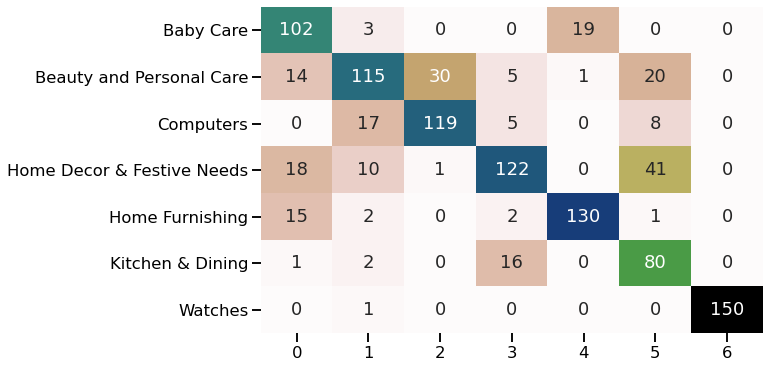

                            precision    recall  f1-score   support

                 Baby Care       0.68      0.82      0.74       124
  Beauty and Personal Care       0.77      0.62      0.69       185
                 Computers       0.79      0.80      0.80       149
Home Decor & Festive Needs       0.81      0.64      0.71       192
           Home Furnishing       0.87      0.87      0.87       150
          Kitchen & Dining       0.53      0.81      0.64        99
                   Watches       1.00      0.99      1.00       151

                  accuracy                           0.78      1050
                 macro avg       0.78      0.79      0.78      1050
              weighted avg       0.79      0.78      0.78      1050



In [74]:
df['cluster_d_label'] = df['cluster_d']
df['cluster_d_label'] = df['cluster_d_label'].replace(0, 'Home Decor & Festive Needs')
df['cluster_d_label'] = df['cluster_d_label'].replace(1, 'Beauty and Personal Care')
df['cluster_d_label'] = df['cluster_d_label'].replace(2, 'Computers')
df['cluster_d_label'] = df['cluster_d_label'].replace(3, 'Watches')
df['cluster_d_label'] = df['cluster_d_label'].replace(4, 'Home Furnishing')
df['cluster_d_label'] = df['cluster_d_label'].replace(5, 'Kitchen & Dining')
df['cluster_d_label'] = df['cluster_d_label'].replace(6, 'Baby Care')
categories_predict = df['cluster_d_label']
categories_true = df['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

In [76]:
df_errors = df[df['cat_1'] != df['cluster_d_label']]
df_errors.shape

(232, 19)

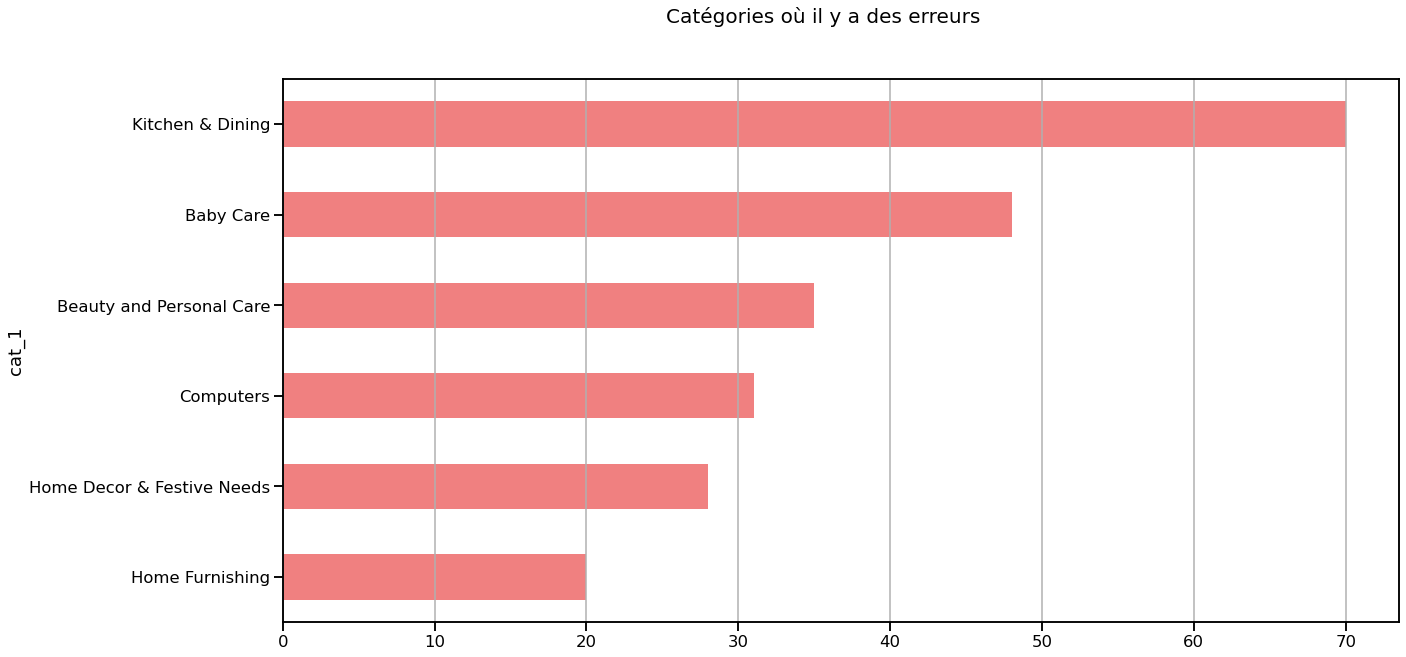

In [78]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle("Catégories où il y a des erreurs", fontsize=20)
df_errors["cat_1"].reset_index().groupby("cat_1").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, color='lightcoral',
        ax=ax).grid(axis='x')
plt.show()

#### Visualisation de la qualité de la classification grâce à un sankey diagram

In [79]:
#Sankey vue d'ensemble
source = [0, 0, 0, 0, 0,           # Watches
          1, 1, 1, 1, 1, 1, 1,     # Baby care  
          2, 2, 2,                 # Kitchen & Dining
          3,                       # Home decor & Festive needs 
          4, 4, 4,                 # Computers
          5, 5, 5, 5, 5,           # Beauty and Personal Care 
          6, 6, 6, 6, 6 ]          # Home furnishing               

target = [7, 8, 9, 11, 12,
          8, 7 , 9, 10, 11, 12, 13, 
          9, 7, 8,
          10,
          11, 8, 13,
          12, 7, 8, 9, 11, 
          13, 7, 8, 11, 12]         

value = [122, 5, 5, 2, 16,
         115, 10, 17, 1, 2, 2, 3,
         119, 1, 30,
         150, 
         130, 1, 19, 
         80, 41, 20, 8, 1,
         102, 18, 14, 15, 1]

label = ['Watches',#0
         'Baby care', #1
         'Kitchen & Dining',#2
         'Home decor & Festive needs',#3
         'Computers', #4
         'Beauty and Personal Care',#5
         'Home furnishing', #6
         
         'Watches', #7
         'Baby care', #8
         'Kitchen & Dining',#9
         'Home decor & Festive needs',#10
         'Computers', #11
         'Beauty and Personal Care',#12
         'Home furnishing', #13
          ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',  
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', ]
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', '#A6E3D7', '#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5',
              '#FEF3C7', '#FEF3C7', '#FEF3C7', 
              '#CBB4D5', 
              '#FF90A1', '#FF90A1', '#FF90A1', 
              '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', 
              '#FFE18F', '#FFE18F', '#FFE18F', '#FFE18F', '#FFE18F']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Qualité de la classification, modèle doc2vec, description",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

### <span class="bg-success"> 1.3 Essais colonne ensemble doc2vec<span> 

1050
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.032s...
[t-SNE] Computed neighbors for 1050 samples in 0.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.503267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.311333
[t-SNE] KL divergence after 3700 iterations: 0.742798


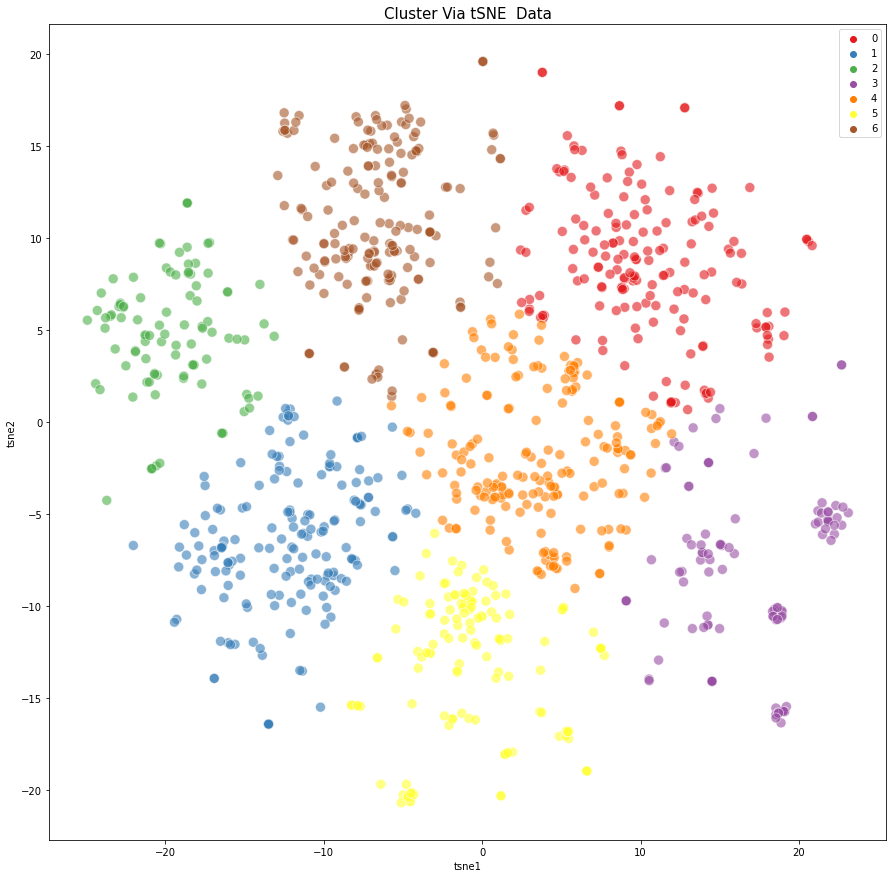

Adjusted Rand Index: 0.522


In [15]:
#=========================================  Tsne puis K means =========================================================

#jeu de données
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df['ensemble'] = df['product_name'] + df['description']
df['cat_1']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])

#corpus
ensemble_corpus = (list(read_corpus(df, 'ensemble'))) 

# using distributed memory model
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=300, min_count=5, dm_mean=0, epochs=100, seed=42, workers=8)
model.build_vocab(ensemble_corpus)
#train model
model.train(ensemble_corpus, total_examples=model.corpus_count, epochs=model.epochs)

print(len(model.docvecs.doctag_syn0))

tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(model.docvecs.doctag_syn0)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])


kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)


plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

df['cluster_e'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_e']
from sklearn import metrics
ari_doc2vec_ensemble = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

## <span class="bg-info"> 2. Avec nettoyage du jeu de données<span>

### <span class="bg-success"> 2.1 Essais colonne product_name doc2vec<span> 

1050
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.033s...
[t-SNE] Computed neighbors for 1050 samples in 0.608s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.536567
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.871666
[t-SNE] KL divergence after 2600 iterations: 0.449441


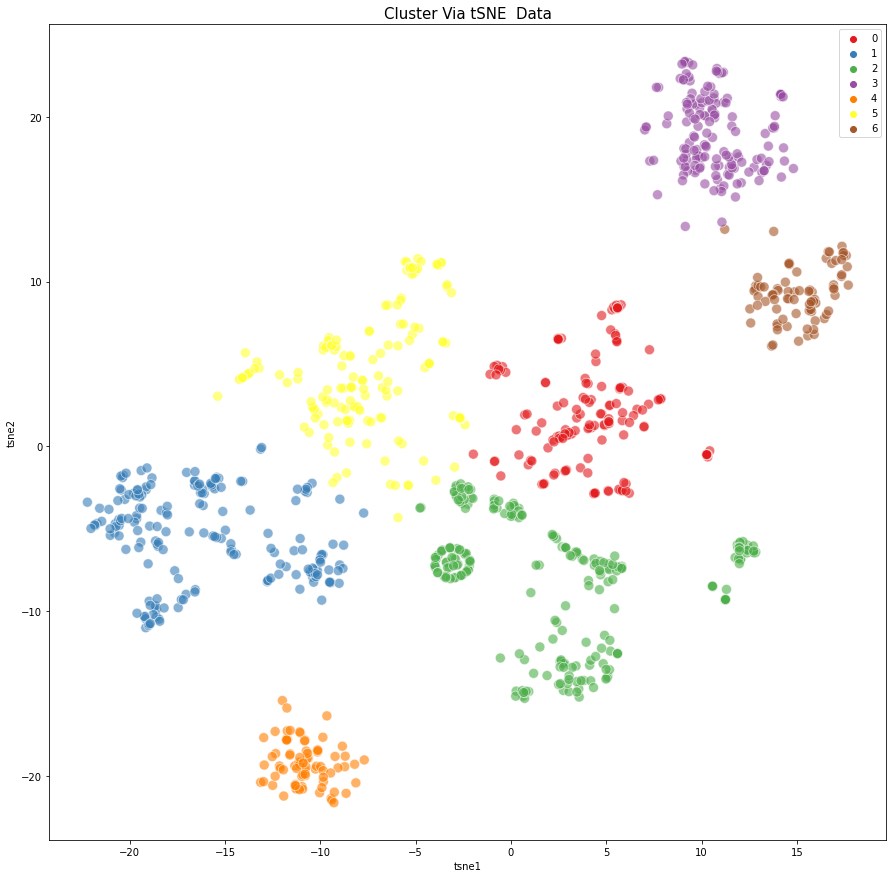

Adjusted Rand Index: 0.555


In [16]:
#=========================================  Tsne puis K means =========================================================

#jeu de données
df = pd.read_csv('data_clean.csv')
df['cat_1']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])

#corpus
product_name_corpus = (list(read_corpus(df, 'product_name'))) 

# using distributed memory model
model = gensim.models.doc2vec.Doc2Vec(dm=0, dbow_words=1, vector_size=300, min_count=5, dm_mean=1, epochs=100, seed=42, workers=8)
model.build_vocab(product_name_corpus)
#train model
model.train(product_name_corpus, total_examples=model.corpus_count, epochs=model.epochs)

print(len(model.docvecs.doctag_syn0))

tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(model.docvecs.doctag_syn0)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])


kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)


plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

df['cluster_pn'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_pn']
from sklearn import metrics
ari_doc2vec_pname_N = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

### <span class="bg-success"> 2.2 Essais colonne description doc2vec<span> 

1050
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.033s...
[t-SNE] Computed neighbors for 1050 samples in 0.586s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.368349
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.599903
[t-SNE] KL divergence after 2900 iterations: 0.438720
KMeans tSNE tsne_df Silhouette Score: 0.47385266423225403


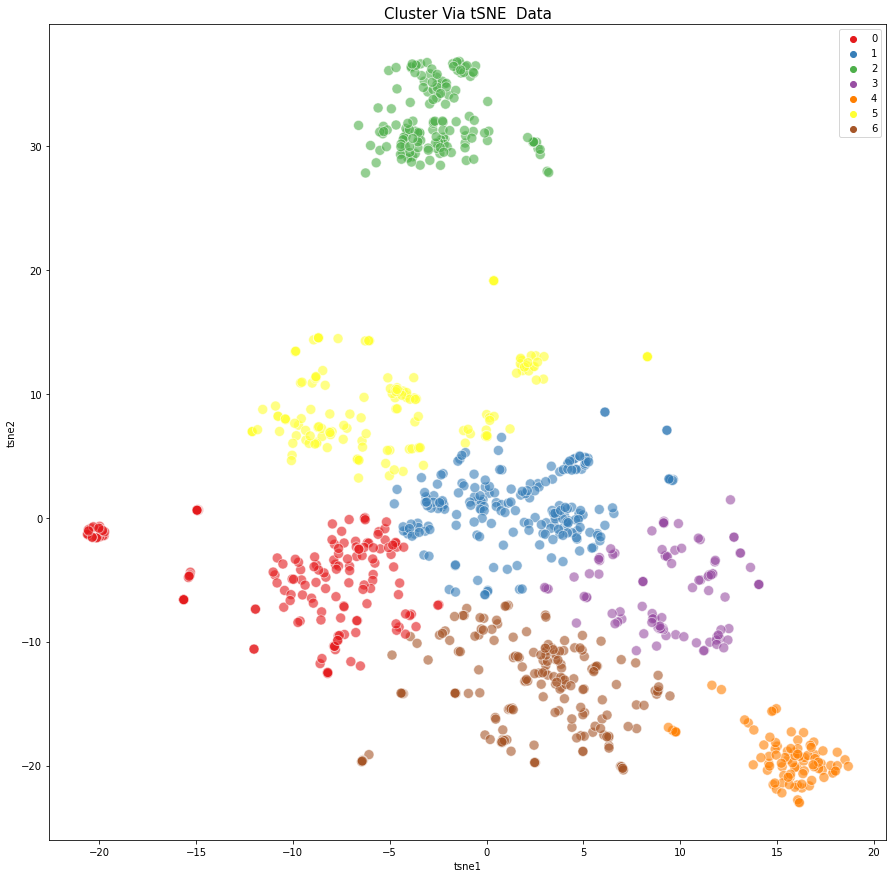

Adjusted Rand Index: 0.422


In [9]:
#=========================================  Tsne puis K means =========================================================

#jeu de données
df = pd.read_csv('data_clean.csv')
df['cat_1']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])

#corpus
description_corpus = (list(read_corpus(df, 'description'))) 

# using distributed memory model
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=300, min_count=10, dm_mean=1, epochs=30, seed=42, workers=8)
model.build_vocab(description_corpus)
#train model
model.train(description_corpus, total_examples=model.corpus_count, epochs=model.epochs)

print(len(model.docvecs.doctag_syn0))

tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(model.docvecs.doctag_syn0)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])


kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
print('KMeans tSNE tsne_df Silhouette Score: {}'.format(silhouette_score(tsne_df, kmeans_tsne_df.labels_, metric='euclidean')))
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)


plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

df['cluster_d'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_d']
from sklearn import metrics
ari_doc2vec_desc_N = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

### <span class="bg-success"> 2.3 Essais colonne ensemble doc2vec<span> 

1050
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.034s...
[t-SNE] Computed neighbors for 1050 samples in 0.582s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.565997
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.663071
[t-SNE] KL divergence after 4000 iterations: 0.432182
KMeans tSNE tsne_df Silhouette Score: 0.5118759274482727


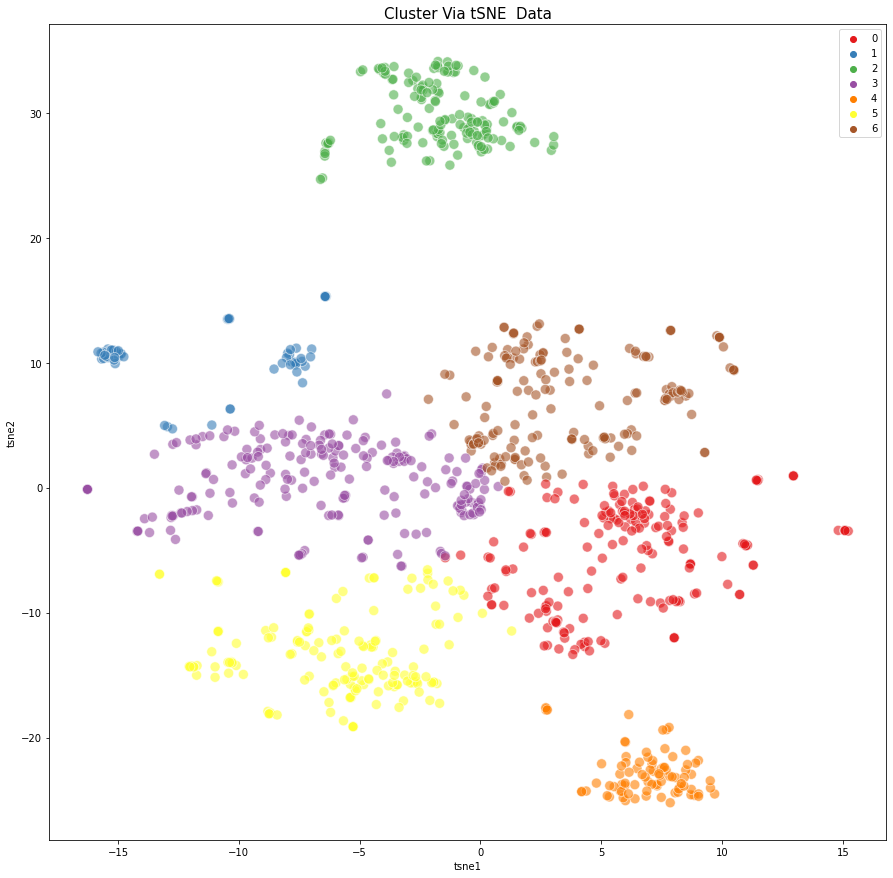

Adjusted Rand Index: 0.476


In [10]:
#=========================================  Tsne puis K means =========================================================

#jeu de données
df = pd.read_csv('data_clean.csv')
df['ensemble'] = df['product_name'] + df['description']
df['cat_1']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])

#corpus
ensemble_corpus = (list(read_corpus(df, 'ensemble'))) 

# using distributed memory model
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=300, min_count=10, dm_mean=1, epochs=30, seed=42, workers=8)
model.build_vocab(ensemble_corpus)
#train model
model.train(ensemble_corpus, total_examples=model.corpus_count, epochs=model.epochs)

print(len(model.docvecs.doctag_syn0))

tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(model.docvecs.doctag_syn0)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])


kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
print('KMeans tSNE tsne_df Silhouette Score: {}'.format(silhouette_score(tsne_df, kmeans_tsne_df.labels_, metric='euclidean')))
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)


plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

df['cluster_e'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_e']
from sklearn import metrics
ari_doc2vec_ensemble_N = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

## <span class="bg-info"> 3. Résultats<span>

In [18]:
resultats = pd.DataFrame({
    'Colonne' : ['product_name', 'description','ensemble','product_name', 'description','ensemble'],
    'Nettoyage' : ['SANS', 'SANS','SANS','AVEC', 'AVEC', 'AVEC'],
    'modèle' : ['doc2vec', 'doc2vec','doc2vec', 'doc2vec', 'doc2vec', 'doc2vec'],
    'ARI' : [ ari_doc2vec_pname, ari_doc2vec_desc, ari_doc2vec_ensemble, ari_doc2vec_pname_N, ari_doc2vec_desc_N, ari_doc2vec_ensemble_N]})
resultats.set_index('modèle')

,Colonne,Nettoyage,ARI
modèle,,,
doc2vec,product_name,SANS,0.1128
doc2vec,description,SANS,0.5802
doc2vec,ensemble,SANS,0.5361
doc2vec,product_name,AVEC,0.1125
doc2vec,description,AVEC,0.4222
doc2vec,ensemble,AVEC,0.4756
